In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time


In [3]:
extended_train_features = pd.read_csv('extended_train_features.csv')
extended_train_labels = pd.read_csv('extended_train_labels.csv')

extended_train_features

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,0.200000,0.341275,0.970637,0.125,0.30,0.050505,0.100000,1,1,...,0,0,0,0,0,0,0,0,1,0
1,28830,0.266667,0.630694,0.223761,0.125,0.10,0.070707,0.166667,0,1,...,0,0,0,0,0,0,0,0,1,0
2,94947,0.700000,0.254380,0.714013,0.125,0.10,0.040404,0.100000,0,1,...,0,0,0,0,0,0,0,0,1,0
3,590882,0.733333,0.292922,0.850959,0.125,0.10,0.050505,0.100000,0,1,...,0,0,0,0,0,0,0,0,1,0
4,201944,0.366667,0.091801,0.118405,0.250,0.30,0.070707,0.233333,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258472,688636,0.833333,0.935529,0.128989,0.000,0.55,0.050505,0.033333,0,1,...,0,0,0,1,0,0,0,0,1,0
258473,669485,0.566667,0.501051,0.163921,0.125,0.00,0.050505,0.100000,0,1,...,0,0,0,0,0,0,0,0,1,0
258474,602512,0.566667,0.035739,0.649558,0.250,0.55,0.050505,0.166667,0,1,...,0,0,0,0,0,0,0,0,1,0
258475,151409,0.866667,0.027330,0.147291,0.125,0.10,0.131313,0.133333,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# Remove building id
exclude = ['building_id']
extended_train_features = extended_train_features.loc[:,[i for i in list(extended_train_features.columns) if i not in exclude]]


In [5]:
#Standardize features
scaler = StandardScaler()
extended_train_features = scaler.fit_transform(extended_train_features)

extended_train_features[1]

array([-7.34060455e-01,  4.81676775e-01, -9.45157689e-01, -1.74844876e-01,
       -5.93386459e-01, -3.70185724e-03,  8.20679674e-01, -3.10128652e-01,
        5.57507901e-01, -1.87914563e-01, -1.36427690e-01, -2.67694704e-01,
       -2.85582000e-01, -5.84187002e-01, -3.04875566e-01, -2.11218361e-01,
       -1.27160296e-01, -1.23352527e-01,  3.83742508e-02, -3.54918395e-01,
       -2.62529228e-01, -1.86364284e-01, -8.99816220e-02, -3.07389510e-02,
       -1.90735687e-02, -3.28129382e-02, -1.37698198e-02, -1.21258662e-02,
       -9.43348773e-03, -7.19175840e-02, -7.41660106e-02, -2.06344565e-01,
        4.35591744e-01, -2.40653670e-01, -2.49103168e-01, -3.97928247e-01,
        5.49220681e+00, -2.21913650e+00,  6.53248303e-01, -5.56995171e-01,
       -2.57791087e-01, -2.02501378e+00, -4.43322096e-02, -3.23321018e-01,
        3.07467917e+00, -6.16601271e-02, -4.25630094e-01,  7.60404914e-01,
       -2.20388793e-01, -4.47229167e-01, -2.29622603e-01, -9.22693171e-02,
        5.36087611e-01, -

In [6]:
features = extended_train_features

labels = extended_train_labels['damage_grade']
labels = np.asarray(labels)#[index]

In [7]:
print(extended_train_features.shape)
print(features.shape)

(258477, 68)
(258477, 68)


### Principal Component Analysis

In [58]:
from sklearn.decomposition import PCA

In [64]:
# Apply PCA
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(features)
print (np.sum(pca.explained_variance_ratio_)) 
print (principalComponents.shape) 
print (labels.shape) 

0.9512736531975479
(258477, 50)
(258477,)


### Split data

In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 5, shuffle=True)
print('Shape of data')
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)
print("")

Shape of data
(180933, 68)
(180933,)
(77544, 68)
(77544,)



### Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [67]:
#Training the model

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
# Predict with trained model
predictions = random_forest.predict(test_features)

In [69]:
f1 = f1_score(test_labels, predictions, average = 'micro')
print(f1)

# With 68 features: 0.7112735995047973
# With 50 principal components: 0.6675435881564016

0.6675435881564016


## Clustering

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score

#### Silhouette

In [82]:
# Reducing training data set to later apply Silhouette technique (original data)

import random

index = np.random.choice(len(extended_train_features), size = 5000)
sample = extended_train_features[index]

Text(0, 0.5, 'Average silhouette width')

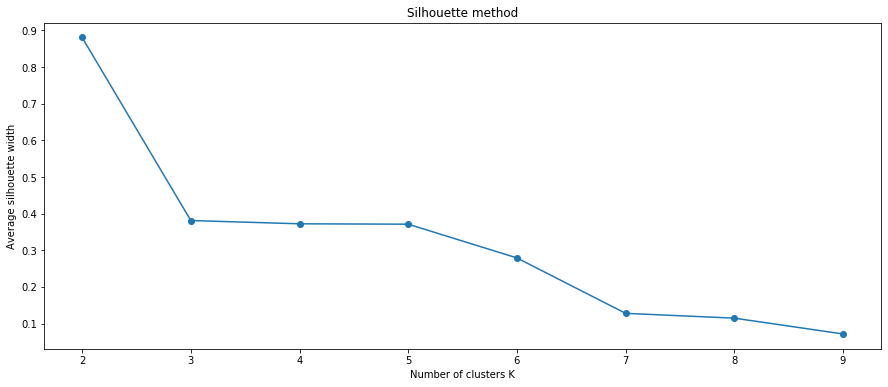

In [83]:
# Applying the silhouette technique 

silhouette = []
component_range = list(range(2, 10))

for k in component_range:
    kmeans = KMeans(n_clusters = k).fit(sample)
    score = silhouette_score(sample, kmeans.predict(sample), metric = 'euclidean')
    silhouette.append(score)
    
plt.figure(figsize=(15, 6))
plt.plot(component_range, silhouette, '-o')
plt.title("Silhouette method")
plt.xlabel(r'Number of clusters K')
plt.ylabel('Average silhouette width')

In [ ]:
# QUESTION: This graph suggests that 2 is the number of clusters. But the original labels have 3 clases. Should I 
#  go with 3 or 2 classes? And how this decision could affect the score?

#### Kmeans

In [94]:
t1 = time.time()
k = 2
kmeans = KMeans(n_clusters=k, random_state=0).fit(train_features)
kmeans_labels = kmeans.labels_
kmeans_prediction = kmeans.predict(test_features)
print("Time execution:", time.time() - t1)

Time execution: 3.993295907974243


#### Spectral Clustering

In [89]:
sp = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
sp.fit(train_features)
labels = sp.labels_


KeyboardInterrupt: 

#### Agglomerative clustering

In [ ]:
t1 = time.time()
agglomerative = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')  
agglomerative_predict = cluster.fit_predict(train_features)
print("Time execution:", time.time() - t1)

### Performance comparison

In [92]:
res = [('K-means', kmeans_labels)]

In [93]:
for r in res:
    print(r[0])
    print("Homogeneity: %0.3f" % homogeneity_score(train_labels, r[1]))
    print("Completeness: %0.3f" % completeness_score(train_labels, r[1]))
    print("V-measure: %0.3f" % v_measure_score(train_labels, r[1]))
    print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(train_labels, r[1]))
    print("Adjusted Mutual Information: %0.3f"% adjusted_mutual_info_score(train_labels, r[1]))
#     print("Silhouette Coefficient: %0.3f"% silhouette_score(train_features, r[1]))
    print("==========================")

K-means
Homogeneity: 0.065
Completeness: 0.191
V-measure: 0.097
Adjusted Rand Index: 0.070
Adjusted Mutual Information: 0.097
